<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Supervised_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Clock Drawing Image Classification with Convolutional Neural Networks
### Stacey Beck and Ian Byrne

- Split data into sets of Training (x = image arrays ; y = labels), Test (~10% image arrays), and Validation (~10% of the Training). 
- Build CNN using Pytorch for Training and Test:
  - Specify CUDA
  - 2D convolution, Normalization (for faster training), Non-linear Activation Function (ex. RELU), Max Pooling (downsampling to reduce learned parameters).
  - Define Layers 
  - Build Forward and backward pass
  - Define optimizer (due to many - deep - nodes) ex) ADAM
  - Calculate Loss (BCE)
  - Calculate Accuracy, Precision, Recall (Confusion Matrix)
  - Plot ROC and print Confusion Matrix



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
#!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 580, done.
remote: Counting objects: 100% (580/580), done.
remote: Compressing objects: 100% (479/479), done.
remote: Total 580 (delta 320), reused 219 (delta 92), pack-reused 0
Receiving objects: 100% (580/580), 4.29 MiB | 6.30 MiB/s, done.
Resolving deltas: 100% (320/320), done.
/content/MADSmilestone2


In [3]:
!pip install torchmetrics

# General Libraries
import pandas as pd
import numpy as np

# Custom Libraries
import Loading.load_data as ld
import ImagePlayground.Images

# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# To Evaluate model
from tqdm import tqdm
import torchmetrics
from torchmetrics import ConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To visualize model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread

# To split the data
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 282 kB 15.1 MB/s 


In [ ]:
#!rm -rf /content/MADSmilestone2

# Build CNN Model using Pytorch


### Building and Training
Architecture choices influenced from: 

https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/

https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b

https://towardsdatascience.com/how-does-sparse-convolution-work-3257a0a8fd1

In [4]:
# Define some of the hyperparameters and training variables
#epochs = 2
#batch_size = 25
learning_rate = .001
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)

accuracy_stats = {
    'train': [],
    'val': []
}

loss_stats = {
    'train': [],
    'val': []
}
#activation function

In [5]:
# Load numpy array files, add dimension of 1 for gray scale, and zip images and labels 
# get zipped im label and separate label tensors
tr_im_path = "Dementia_label_data/balanced_training.npy"
tr_lb_path = "Dementia_label_data/balanced_train_labels.npy"
val_im_path = "Dementia_label_data/val_im_nobal.npy"
val_lb_path = "Dementia_label_data/val_labels_im_nobal.npy"
tst_im_path = "Dementia_label_data/test_im_nobal.npy"
tst_lb_path = "Dementia_label_data/val_labels_im_nobal.npy"

training_data, y_train_tensor = ld.load_np_files(tr_im_path, tr_lb_path)
validation_data, y_val_tensor = ld.load_np_files(val_im_path, val_lb_path)
test_data, y_test_tensor = ld.load_np_files(tst_im_path, tst_lb_path)


(23535, 1, 368, 284)
(2544, 1, 368, 284)
(2541, 1, 368, 284)


In [55]:
# Get image data and label tensors
train_loader = torch.utils.data.DataLoader(training_data, batch_size = 25, shuffle = True) 
validate_loader = torch.utils.data.DataLoader(validation_data, batch_size = 1)#, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1)#, shuffle = True)


#Labels 
classes = (0, 1, 2)

torch.LongTensor
torch.Size([4, 1, 368, 284])


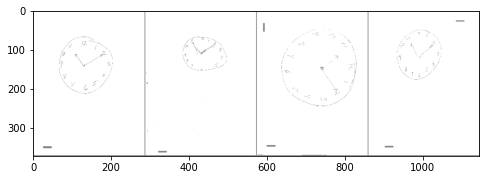

Labels:
    2              2              0              0


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
#print(images.size())
print(images.type())
#images = images.unsqueeze(1)
print(images.size())
# show images
imshow(torchvision.utils.make_grid(images, nrow = 4))
# print labels
print('Labels:')
print('          '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

#Printing as RGB, just using basic pytorch dataloader likely converting to rbg

In [10]:
# Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.backends.cudnn.benchmark = True




class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,386, 284, 16)

    #Normalize each output to help w/ faster learning                       
    self.bn1 = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 16)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640    
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248                     
    self.bn2 = nn.BatchNorm2d(32) 
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 32)
                            
    # Flatten
    self.fc1 = nn.Linear(32*92*71,120)
    self.fc2 = nn.Linear(120, 30)
    self.fc3 = nn.Linear(30, 3) # left with 3 for the three classes






  def forward(self, x):
    x = self.pool1(self.bn1(F.relu(self.conv1(x))))
    x = self.pool2(self.bn2(F.relu(self.conv3(F.relu(self.conv2(x))))))
    x = x.view(x.size(0),32*92*71)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x



train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")


# Create model object 
model = ConvNet().to(float).to(device)
if torch.cuda.is_available():
    model.cuda()
    print('Model training on GPU')

#for param in model.parameters():
  #print(str(param.data.numpy().shape)+'\n')
  #print("weights fc1: ", model.fc1.weight)
  #print("weights fc3: ", model.fc3.weight)

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

#Optimizer (can use SGD or ADAM)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)#, momentum = 0.9) #or ADAM/ momentum
#acc = 0 # accuracy
#epoch = 0 # training episodes
#n_total_steps = len(train_loader) 

print(model)






def train_val_model(epochs):
  for epoch in tqdm(range(1, epochs + 1)):

    # TRAINING ********************************
    train_epoch_loss = 0
    train_epoch_acc = 0

    # set model in training mode (recommended)
    model.train()

    #losses = []
    #running_loss = 0.0
    #num_times = 0
    #for i, (images, labels) in enumerate(train_loader, 0):
    for x_train_batch, y_train_batch in train_loader:
      x_train_batch = x_train_batch.to(float).to(device) # for GPU support
      y_train_batch = y_train_batch.to(device) 

      # sets gradients to 0 to prevent interference with previous epoch
      optimizer.zero_grad()

      # Forward pass through NN
      y_train_pred = model(x_train_batch)#.to(float))
      train_loss = criterion(y_train_pred, y_train_batch)
      train_acc = accuracy(y_train_pred, y_train_batch)

      # Backward pass, updating weights
      train_loss.backward()
      optimizer.step()

      # Statistics
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()


    # VALIDATION****************************************   
    with torch.set_grad_enabled(False):
      val_epoch_loss = 0
      val_epoch_acc = 0
      model.eval()
      for x_val_batch, y_val_batch in validate_loader:
        x_val_batch =  x_val_batch.to(float).to(device)
        y_val_batch = y_val_batch.to(device)
            
        # Forward pass
        y_val_pred = model(x_val_batch)   
        val_loss = criterion(y_val_pred, y_val_batch)
        val_acc = accuracy(y_val_pred, y_val_batch)
            
        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(validate_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(validate_loader))
                              
    
    print(f'Epoch {epoch+0:03}: Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(validate_loader):.5f}') 
    print(f'Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(validate_loader):.3f}')

      # Forward pass through NN
      #outputs = model(images.to(float))
      #loss = criterion(outputs, labels)

      # Backward pass, updating weights
      #loss.backward()
      #optimizer.step()
      #print(model.fc1.weight.detach().numpy())

      # Statistics 
      #running_loss += loss.item()
      # Track every 100th loss:
      #if i % 100 == 0:
        #losses.append(loss.item())
        #num_times = num_times + 1

      # print every 500th batch
      #if i % 500 == 0:
        #print("epoch: {} loss: {}".format(i, loss))
        #print('[%d %d] loss %.4f'% (epoch + 1, i + 1, running_loss/500))
        #running_loss = 0.0

    #print("\nFinished training Epoch {}\n".format(epoch + 1))
  

    # Plot the loss
    #plt.plot([i for i in range(num_times)],losses, label = 'epoch' + str(epoch))
    #plt.legend(loc = 1, mode = 'expanded', shadow = True, ncol = 2)
  #plt.show()

  los_chart(losses)







def los_chart(losses):
  plt.plot(losses)
  plt.title('loss vs epochs')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()








def accuracy(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_prob = torch.max(y_pred_softmax, dim = 1)

  correct_pred = (y_pred_prob == y_test).float()
  acc = correct_pred.sum() / len(correct_pred)

  acc = torch.round(acc * 100)

  return acc



  """
  model.eval()
  # Calculate performance
  correct = 0
  total = 0
  accuracy = 0
  with torch.set_grad_enabled(False):
      #model.to(float)
      for batches in test_loader:
        x_test, y_test = batches
        x_test = x_test.to(float).to(device)
        y_test = y_test.to(float).to(device)
        y_pred = model(x_test)
        _,y_pred = torch.max(y_pred.data, 1)# returns strongest label val and index
        total += y_test.size(0)
        #print(y_pred.size())
        #print(y_test.size())
      
        correct += (y_pred == y_test).sum().item()
        accuracy = (correct/total) * 100
      
      
      print('Accuracy = '+str(accuracy))"""


"""# TESTING****************************************   
    with torch.set_grad_enabled(False):
        
        tst_epoch_loss = 0
        tst_epoch_acc = 0
        
        model.eval()
        for x_tst_batch, y_tst_batch in test_loader:
            x_tst_batch = x_tst_batch.to(float).to(device) # for GPU support
            y_tst_batch = y_tst_batch.to(device)
            
            # Forward pass
            y_tst_pred = model(x_tst_batch)
            tst_loss = criterion(y_tst_pred, y_tst_batch)
            tst_acc = accuracy(y_tst_pred, y_tst_batch)
            
            tst_epoch_loss += tst_loss.item()
            tst_epoch_acc += tst_acc.item()"""












if __name__ == '__main__':
  train_val_model(300)













CUDA is available! Training on GPU...
Model training on GPU
ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=209024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
)


  0%|          | 1/300 [01:13<6:07:09, 73.68s/it]

Epoch 001: Train Loss: 1.05045 | Val Loss: 0.98886
Train Acc: 43.887 | Val Acc: 52.005


  1%|          | 2/300 [02:27<6:06:39, 73.82s/it]

Epoch 002: Train Loss: 0.90383 | Val Loss: 0.98587
Train Acc: 57.183 | Val Acc: 48.781


  1%|          | 3/300 [03:40<6:04:22, 73.61s/it]

Epoch 003: Train Loss: 0.66970 | Val Loss: 0.94547
Train Acc: 72.344 | Val Acc: 53.970


  1%|▏         | 4/300 [04:52<5:59:04, 72.78s/it]

Epoch 004: Train Loss: 0.38692 | Val Loss: 1.12106
Train Acc: 87.732 | Val Acc: 45.165


  2%|▏         | 5/300 [06:04<5:55:36, 72.33s/it]

Epoch 005: Train Loss: 0.16213 | Val Loss: 1.12191
Train Acc: 97.057 | Val Acc: 57.036


  2%|▏         | 6/300 [07:16<5:55:20, 72.52s/it]

Epoch 006: Train Loss: 0.05585 | Val Loss: 1.54054
Train Acc: 99.775 | Val Acc: 41.863


  2%|▏         | 7/300 [08:30<5:55:20, 72.77s/it]

Epoch 007: Train Loss: 0.02242 | Val Loss: 1.50958
Train Acc: 99.987 | Val Acc: 47.091


  3%|▎         | 8/300 [09:41<5:52:08, 72.36s/it]

Epoch 008: Train Loss: 0.01224 | Val Loss: 1.61524
Train Acc: 100.000 | Val Acc: 46.777


  3%|▎         | 9/300 [10:53<5:49:39, 72.10s/it]

Epoch 009: Train Loss: 0.00802 | Val Loss: 1.63795
Train Acc: 100.000 | Val Acc: 47.131


  3%|▎         | 10/300 [12:04<5:47:33, 71.91s/it]

Epoch 010: Train Loss: 0.00590 | Val Loss: 1.69892
Train Acc: 100.000 | Val Acc: 47.956


  4%|▎         | 11/300 [13:16<5:45:44, 71.78s/it]

Epoch 011: Train Loss: 0.00464 | Val Loss: 1.78052
Train Acc: 100.000 | Val Acc: 46.777


  4%|▍         | 12/300 [14:29<5:46:27, 72.18s/it]

Epoch 012: Train Loss: 0.00372 | Val Loss: 1.80950
Train Acc: 100.000 | Val Acc: 46.344


  4%|▍         | 13/300 [15:42<5:46:45, 72.49s/it]

Epoch 013: Train Loss: 0.00317 | Val Loss: 1.83266
Train Acc: 100.000 | Val Acc: 47.131


  5%|▍         | 14/300 [16:54<5:44:49, 72.34s/it]

Epoch 014: Train Loss: 0.00267 | Val Loss: 1.88047
Train Acc: 100.000 | Val Acc: 46.855


  5%|▌         | 15/300 [18:06<5:43:01, 72.21s/it]

Epoch 015: Train Loss: 0.00237 | Val Loss: 1.87161
Train Acc: 100.000 | Val Acc: 46.777


  5%|▌         | 16/300 [19:18<5:41:20, 72.11s/it]

Epoch 016: Train Loss: 0.00208 | Val Loss: 1.82399
Train Acc: 100.000 | Val Acc: 46.619


  6%|▌         | 17/300 [20:30<5:39:54, 72.06s/it]

Epoch 017: Train Loss: 0.00183 | Val Loss: 1.90581
Train Acc: 100.000 | Val Acc: 47.288


  6%|▌         | 18/300 [21:42<5:38:29, 72.02s/it]

Epoch 018: Train Loss: 0.00166 | Val Loss: 1.96437
Train Acc: 100.000 | Val Acc: 47.248


  6%|▋         | 19/300 [22:54<5:37:24, 72.05s/it]

Epoch 019: Train Loss: 0.00153 | Val Loss: 1.97548
Train Acc: 100.000 | Val Acc: 46.659


  7%|▋         | 20/300 [24:06<5:36:22, 72.08s/it]

Epoch 020: Train Loss: 0.00139 | Val Loss: 1.97032
Train Acc: 100.000 | Val Acc: 47.406


  7%|▋         | 21/300 [25:17<5:34:15, 71.88s/it]

Epoch 021: Train Loss: 0.00126 | Val Loss: 2.00382
Train Acc: 100.000 | Val Acc: 46.973


  7%|▋         | 22/300 [26:29<5:32:24, 71.74s/it]

Epoch 022: Train Loss: 0.00119 | Val Loss: 2.01070
Train Acc: 100.000 | Val Acc: 47.091


  8%|▊         | 23/300 [27:40<5:30:35, 71.61s/it]

Epoch 023: Train Loss: 0.00110 | Val Loss: 2.02328
Train Acc: 100.000 | Val Acc: 47.209


  8%|▊         | 24/300 [28:51<5:28:49, 71.48s/it]

Epoch 024: Train Loss: 0.00102 | Val Loss: 2.01254
Train Acc: 100.000 | Val Acc: 47.209


  8%|▊         | 25/300 [30:03<5:27:27, 71.44s/it]

Epoch 025: Train Loss: 0.00096 | Val Loss: 1.99096
Train Acc: 100.000 | Val Acc: 47.248


  9%|▊         | 26/300 [31:14<5:26:04, 71.40s/it]

Epoch 026: Train Loss: 0.00092 | Val Loss: 2.08237
Train Acc: 100.000 | Val Acc: 47.052


  9%|▉         | 27/300 [32:25<5:24:41, 71.36s/it]

Epoch 027: Train Loss: 0.00086 | Val Loss: 2.10100
Train Acc: 100.000 | Val Acc: 47.327


  9%|▉         | 28/300 [33:36<5:23:19, 71.32s/it]

Epoch 028: Train Loss: 0.00080 | Val Loss: 2.07039
Train Acc: 100.000 | Val Acc: 46.462


 10%|▉         | 29/300 [34:48<5:22:04, 71.31s/it]

Epoch 029: Train Loss: 0.00076 | Val Loss: 2.08471
Train Acc: 100.000 | Val Acc: 47.642


 10%|█         | 30/300 [35:59<5:20:45, 71.28s/it]

Epoch 030: Train Loss: 0.00074 | Val Loss: 2.10083
Train Acc: 100.000 | Val Acc: 47.170


 10%|█         | 31/300 [37:10<5:19:49, 71.34s/it]

Epoch 031: Train Loss: 0.00069 | Val Loss: 2.12039
Train Acc: 100.000 | Val Acc: 47.013


 11%|█         | 32/300 [38:22<5:18:32, 71.32s/it]

Epoch 032: Train Loss: 0.00066 | Val Loss: 2.13041
Train Acc: 100.000 | Val Acc: 47.052


 11%|█         | 33/300 [39:33<5:17:21, 71.32s/it]

Epoch 033: Train Loss: 0.00062 | Val Loss: 2.14038
Train Acc: 100.000 | Val Acc: 47.799


 11%|█▏        | 34/300 [40:44<5:16:02, 71.29s/it]

Epoch 034: Train Loss: 0.00060 | Val Loss: 2.03580
Train Acc: 100.000 | Val Acc: 46.973


 12%|█▏        | 35/300 [41:55<5:14:53, 71.30s/it]

Epoch 035: Train Loss: 0.00057 | Val Loss: 2.14923
Train Acc: 100.000 | Val Acc: 46.973


 12%|█▏        | 36/300 [43:07<5:13:40, 71.29s/it]

Epoch 036: Train Loss: 0.00057 | Val Loss: 2.18573
Train Acc: 100.000 | Val Acc: 47.052


 12%|█▏        | 37/300 [44:18<5:12:25, 71.27s/it]

Epoch 037: Train Loss: 0.00053 | Val Loss: 2.15825
Train Acc: 100.000 | Val Acc: 47.524


 13%|█▎        | 38/300 [45:29<5:11:06, 71.25s/it]

Epoch 038: Train Loss: 0.00051 | Val Loss: 2.16176
Train Acc: 100.000 | Val Acc: 46.777


 13%|█▎        | 39/300 [46:41<5:10:13, 71.31s/it]

Epoch 039: Train Loss: 0.00049 | Val Loss: 2.21660
Train Acc: 100.000 | Val Acc: 47.091


 13%|█▎        | 40/300 [47:52<5:08:51, 71.28s/it]

Epoch 040: Train Loss: 0.00048 | Val Loss: 2.09132
Train Acc: 100.000 | Val Acc: 46.541


 14%|█▎        | 41/300 [49:03<5:07:43, 71.29s/it]

Epoch 041: Train Loss: 0.00046 | Val Loss: 2.14719
Train Acc: 100.000 | Val Acc: 47.170


 14%|█▍        | 42/300 [50:14<5:06:22, 71.25s/it]

Epoch 042: Train Loss: 0.00045 | Val Loss: 2.22348
Train Acc: 100.000 | Val Acc: 47.288


 14%|█▍        | 43/300 [51:26<5:05:23, 71.30s/it]

Epoch 043: Train Loss: 0.00043 | Val Loss: 2.24247
Train Acc: 100.000 | Val Acc: 47.366


 15%|█▍        | 44/300 [52:37<5:04:09, 71.29s/it]

Epoch 044: Train Loss: 0.00041 | Val Loss: 2.28127
Train Acc: 100.000 | Val Acc: 47.052


 15%|█▌        | 45/300 [53:48<5:03:04, 71.31s/it]

Epoch 045: Train Loss: 0.00041 | Val Loss: 2.20900
Train Acc: 100.000 | Val Acc: 47.524


 15%|█▌        | 46/300 [55:00<5:01:45, 71.28s/it]

Epoch 046: Train Loss: 0.00039 | Val Loss: 2.26641
Train Acc: 100.000 | Val Acc: 47.366


 16%|█▌        | 47/300 [56:11<5:00:40, 71.30s/it]

Epoch 047: Train Loss: 0.00038 | Val Loss: 2.25219
Train Acc: 100.000 | Val Acc: 47.013


 16%|█▌        | 48/300 [57:22<4:59:26, 71.30s/it]

Epoch 048: Train Loss: 0.00037 | Val Loss: 2.22144
Train Acc: 100.000 | Val Acc: 47.366


 16%|█▋        | 49/300 [58:33<4:58:16, 71.30s/it]

Epoch 049: Train Loss: 0.00036 | Val Loss: 2.23483
Train Acc: 100.000 | Val Acc: 47.013


 17%|█▋        | 50/300 [59:45<4:56:56, 71.27s/it]

Epoch 050: Train Loss: 0.00035 | Val Loss: 2.22041
Train Acc: 100.000 | Val Acc: 47.170


 17%|█▋        | 51/300 [1:00:56<4:55:44, 71.26s/it]

Epoch 051: Train Loss: 0.00034 | Val Loss: 2.24580
Train Acc: 100.000 | Val Acc: 47.288


 17%|█▋        | 52/300 [1:02:07<4:54:34, 71.27s/it]

Epoch 052: Train Loss: 0.00034 | Val Loss: 2.22864
Train Acc: 100.000 | Val Acc: 47.091


 18%|█▊        | 53/300 [1:03:18<4:53:25, 71.28s/it]

Epoch 053: Train Loss: 0.00033 | Val Loss: 2.24950
Train Acc: 100.000 | Val Acc: 47.288


 18%|█▊        | 54/300 [1:04:30<4:52:18, 71.30s/it]

Epoch 054: Train Loss: 0.00032 | Val Loss: 2.26714
Train Acc: 100.000 | Val Acc: 47.602


 18%|█▊        | 55/300 [1:05:41<4:51:10, 71.31s/it]

Epoch 055: Train Loss: 0.00031 | Val Loss: 2.27350
Train Acc: 100.000 | Val Acc: 47.917


 19%|█▊        | 56/300 [1:06:52<4:49:49, 71.27s/it]

Epoch 056: Train Loss: 0.00030 | Val Loss: 2.29352
Train Acc: 100.000 | Val Acc: 47.563


 19%|█▉        | 57/300 [1:08:04<4:48:31, 71.24s/it]

Epoch 057: Train Loss: 0.00029 | Val Loss: 2.30824
Train Acc: 100.000 | Val Acc: 47.484


 19%|█▉        | 58/300 [1:09:15<4:47:15, 71.22s/it]

Epoch 058: Train Loss: 0.00028 | Val Loss: 2.22412
Train Acc: 100.000 | Val Acc: 47.602


 20%|█▉        | 59/300 [1:10:26<4:46:07, 71.23s/it]

Epoch 059: Train Loss: 0.00027 | Val Loss: 2.26235
Train Acc: 100.000 | Val Acc: 47.524


 20%|██        | 60/300 [1:11:37<4:44:49, 71.21s/it]

Epoch 060: Train Loss: 0.00027 | Val Loss: 2.27452
Train Acc: 100.000 | Val Acc: 47.288


 20%|██        | 61/300 [1:12:48<4:43:37, 71.20s/it]

Epoch 061: Train Loss: 0.00026 | Val Loss: 2.25631
Train Acc: 100.000 | Val Acc: 47.602


 21%|██        | 62/300 [1:13:59<4:42:21, 71.18s/it]

Epoch 062: Train Loss: 0.00026 | Val Loss: 2.31784
Train Acc: 100.000 | Val Acc: 47.248


 21%|██        | 63/300 [1:15:11<4:41:13, 71.20s/it]

Epoch 063: Train Loss: 0.00026 | Val Loss: 2.31760
Train Acc: 100.000 | Val Acc: 47.288


 21%|██▏       | 64/300 [1:16:22<4:40:04, 71.21s/it]

Epoch 064: Train Loss: 0.00025 | Val Loss: 2.28913
Train Acc: 100.000 | Val Acc: 47.524


 22%|██▏       | 65/300 [1:17:33<4:38:57, 71.22s/it]

Epoch 065: Train Loss: 0.00024 | Val Loss: 2.32025
Train Acc: 100.000 | Val Acc: 47.524


 22%|██▏       | 66/300 [1:18:44<4:37:43, 71.21s/it]

Epoch 066: Train Loss: 0.00024 | Val Loss: 2.34760
Train Acc: 100.000 | Val Acc: 47.248


 22%|██▏       | 67/300 [1:19:55<4:36:29, 71.20s/it]

Epoch 067: Train Loss: 0.00023 | Val Loss: 2.33201
Train Acc: 100.000 | Val Acc: 47.209


 23%|██▎       | 68/300 [1:21:07<4:35:18, 71.20s/it]

Epoch 068: Train Loss: 0.00023 | Val Loss: 2.33246
Train Acc: 100.000 | Val Acc: 47.642


 23%|██▎       | 69/300 [1:22:18<4:34:05, 71.19s/it]

Epoch 069: Train Loss: 0.00023 | Val Loss: 2.32776
Train Acc: 100.000 | Val Acc: 47.248


 23%|██▎       | 70/300 [1:23:29<4:32:50, 71.18s/it]

Epoch 070: Train Loss: 0.00022 | Val Loss: 2.37039
Train Acc: 100.000 | Val Acc: 47.681


 24%|██▎       | 71/300 [1:24:40<4:31:41, 71.18s/it]

Epoch 071: Train Loss: 0.00022 | Val Loss: 2.34497
Train Acc: 100.000 | Val Acc: 47.288


 24%|██▍       | 72/300 [1:25:51<4:30:28, 71.18s/it]

Epoch 072: Train Loss: 0.00021 | Val Loss: 2.33655
Train Acc: 100.000 | Val Acc: 47.445


 24%|██▍       | 73/300 [1:27:03<4:29:22, 71.20s/it]

Epoch 073: Train Loss: 0.00021 | Val Loss: 2.34829
Train Acc: 100.000 | Val Acc: 47.170


 25%|██▍       | 74/300 [1:28:14<4:27:56, 71.14s/it]

Epoch 074: Train Loss: 0.00021 | Val Loss: 2.26024
Train Acc: 100.000 | Val Acc: 47.052


 25%|██▌       | 75/300 [1:29:25<4:26:30, 71.07s/it]

Epoch 075: Train Loss: 0.00020 | Val Loss: 2.41036
Train Acc: 100.000 | Val Acc: 47.170


 25%|██▌       | 76/300 [1:30:35<4:25:01, 70.99s/it]

Epoch 076: Train Loss: 0.00020 | Val Loss: 2.34299
Train Acc: 100.000 | Val Acc: 47.681


 26%|██▌       | 77/300 [1:31:46<4:23:45, 70.96s/it]

Epoch 077: Train Loss: 0.00020 | Val Loss: 2.38050
Train Acc: 100.000 | Val Acc: 47.563


 26%|██▌       | 78/300 [1:32:57<4:22:28, 70.94s/it]

Epoch 078: Train Loss: 0.00020 | Val Loss: 2.36656
Train Acc: 100.000 | Val Acc: 47.524


 26%|██▋       | 79/300 [1:34:08<4:21:16, 70.93s/it]

Epoch 079: Train Loss: 0.00019 | Val Loss: 2.34608
Train Acc: 100.000 | Val Acc: 47.406


 27%|██▋       | 80/300 [1:35:19<4:20:03, 70.93s/it]

Epoch 080: Train Loss: 0.00019 | Val Loss: 2.38361
Train Acc: 100.000 | Val Acc: 47.248


 27%|██▋       | 81/300 [1:36:30<4:18:56, 70.95s/it]

Epoch 081: Train Loss: 0.00018 | Val Loss: 2.37405
Train Acc: 100.000 | Val Acc: 47.327


 27%|██▋       | 82/300 [1:37:41<4:17:38, 70.91s/it]

Epoch 082: Train Loss: 0.00018 | Val Loss: 2.39529
Train Acc: 100.000 | Val Acc: 47.170


 28%|██▊       | 83/300 [1:38:52<4:16:30, 70.93s/it]

Epoch 083: Train Loss: 0.00019 | Val Loss: 2.44342
Train Acc: 100.000 | Val Acc: 47.642


 28%|██▊       | 84/300 [1:40:03<4:15:15, 70.90s/it]

Epoch 084: Train Loss: 0.00018 | Val Loss: 2.39544
Train Acc: 100.000 | Val Acc: 47.563


 28%|██▊       | 85/300 [1:41:13<4:14:02, 70.90s/it]

Epoch 085: Train Loss: 0.00018 | Val Loss: 2.33715
Train Acc: 100.000 | Val Acc: 47.366


 29%|██▊       | 86/300 [1:42:24<4:12:45, 70.87s/it]

Epoch 086: Train Loss: 0.00017 | Val Loss: 2.28340
Train Acc: 100.000 | Val Acc: 47.248


 29%|██▉       | 87/300 [1:43:35<4:11:44, 70.91s/it]

Epoch 087: Train Loss: 0.00017 | Val Loss: 2.39154
Train Acc: 100.000 | Val Acc: 47.484


 29%|██▉       | 88/300 [1:44:46<4:10:39, 70.94s/it]

Epoch 088: Train Loss: 0.00016 | Val Loss: 2.44024
Train Acc: 100.000 | Val Acc: 47.366


 30%|██▉       | 89/300 [1:45:57<4:09:36, 70.98s/it]

Epoch 089: Train Loss: 0.00017 | Val Loss: 2.39781
Train Acc: 100.000 | Val Acc: 47.327


 30%|███       | 90/300 [1:47:08<4:08:22, 70.96s/it]

Epoch 090: Train Loss: 0.00016 | Val Loss: 2.37653
Train Acc: 100.000 | Val Acc: 47.131


 30%|███       | 91/300 [1:48:19<4:07:16, 70.99s/it]

Epoch 091: Train Loss: 0.00018 | Val Loss: 2.40688
Train Acc: 100.000 | Val Acc: 47.013


 31%|███       | 92/300 [1:49:30<4:06:04, 70.98s/it]

Epoch 092: Train Loss: 0.00016 | Val Loss: 2.40827
Train Acc: 100.000 | Val Acc: 47.406


 31%|███       | 93/300 [1:50:41<4:04:56, 71.00s/it]

Epoch 093: Train Loss: 0.00015 | Val Loss: 2.37944
Train Acc: 100.000 | Val Acc: 47.366


 31%|███▏      | 94/300 [1:51:52<4:03:45, 71.00s/it]

Epoch 094: Train Loss: 0.00016 | Val Loss: 2.42352
Train Acc: 100.000 | Val Acc: 47.327


 32%|███▏      | 95/300 [1:53:03<4:02:40, 71.02s/it]

Epoch 095: Train Loss: 0.00015 | Val Loss: 2.42574
Train Acc: 100.000 | Val Acc: 47.445


 32%|███▏      | 96/300 [1:54:14<4:01:28, 71.02s/it]

Epoch 096: Train Loss: 0.00015 | Val Loss: 2.38807
Train Acc: 100.000 | Val Acc: 47.524


 32%|███▏      | 97/300 [1:55:25<4:00:17, 71.02s/it]

Epoch 097: Train Loss: 0.00015 | Val Loss: 2.43622
Train Acc: 100.000 | Val Acc: 47.445


 33%|███▎      | 98/300 [1:56:36<3:59:04, 71.01s/it]

Epoch 098: Train Loss: 0.00015 | Val Loss: 2.41301
Train Acc: 100.000 | Val Acc: 47.563


 33%|███▎      | 99/300 [1:57:47<3:57:53, 71.01s/it]

Epoch 099: Train Loss: 0.00014 | Val Loss: 2.41862
Train Acc: 100.000 | Val Acc: 47.327


 33%|███▎      | 100/300 [1:58:58<3:56:34, 70.97s/it]

Epoch 100: Train Loss: 0.00014 | Val Loss: 2.40233
Train Acc: 100.000 | Val Acc: 47.642


 34%|███▎      | 101/300 [2:00:09<3:55:23, 70.97s/it]

Epoch 101: Train Loss: 0.00014 | Val Loss: 2.44191
Train Acc: 100.000 | Val Acc: 47.248


 34%|███▍      | 102/300 [2:01:20<3:54:11, 70.97s/it]

Epoch 102: Train Loss: 0.00015 | Val Loss: 2.39042
Train Acc: 100.000 | Val Acc: 48.192


 34%|███▍      | 103/300 [2:02:31<3:53:03, 70.98s/it]

Epoch 103: Train Loss: 0.00014 | Val Loss: 2.41500
Train Acc: 100.000 | Val Acc: 47.366


 35%|███▍      | 104/300 [2:03:42<3:51:48, 70.96s/it]

Epoch 104: Train Loss: 0.00013 | Val Loss: 2.43157
Train Acc: 100.000 | Val Acc: 47.445


 35%|███▌      | 105/300 [2:04:53<3:50:38, 70.97s/it]

Epoch 105: Train Loss: 0.00014 | Val Loss: 2.43179
Train Acc: 100.000 | Val Acc: 47.131


 35%|███▌      | 106/300 [2:06:04<3:49:28, 70.97s/it]

Epoch 106: Train Loss: 0.00013 | Val Loss: 2.43637
Train Acc: 100.000 | Val Acc: 47.170


 36%|███▌      | 107/300 [2:07:15<3:48:25, 71.01s/it]

Epoch 107: Train Loss: 0.00013 | Val Loss: 2.47367
Train Acc: 100.000 | Val Acc: 47.209


 36%|███▌      | 108/300 [2:08:26<3:47:13, 71.01s/it]

Epoch 108: Train Loss: 0.00013 | Val Loss: 2.40323
Train Acc: 100.000 | Val Acc: 47.406


 36%|███▋      | 109/300 [2:09:37<3:46:03, 71.01s/it]

Epoch 109: Train Loss: 0.00013 | Val Loss: 2.45347
Train Acc: 100.000 | Val Acc: 47.327


 37%|███▋      | 110/300 [2:10:48<3:44:51, 71.01s/it]

Epoch 110: Train Loss: 0.00013 | Val Loss: 2.43679
Train Acc: 100.000 | Val Acc: 47.406


 37%|███▋      | 111/300 [2:11:59<3:43:43, 71.03s/it]

Epoch 111: Train Loss: 0.00013 | Val Loss: 2.44395
Train Acc: 100.000 | Val Acc: 47.288


 37%|███▋      | 112/300 [2:13:10<3:42:30, 71.01s/it]

Epoch 112: Train Loss: 0.00012 | Val Loss: 2.46357
Train Acc: 100.000 | Val Acc: 47.327


 38%|███▊      | 113/300 [2:14:21<3:41:19, 71.01s/it]

Epoch 113: Train Loss: 0.00012 | Val Loss: 2.49515
Train Acc: 100.000 | Val Acc: 47.052


 38%|███▊      | 114/300 [2:15:32<3:40:03, 70.99s/it]

Epoch 114: Train Loss: 0.00012 | Val Loss: 2.47864
Train Acc: 100.000 | Val Acc: 47.366


 38%|███▊      | 115/300 [2:16:43<3:38:54, 71.00s/it]

Epoch 115: Train Loss: 0.00012 | Val Loss: 2.47483
Train Acc: 100.000 | Val Acc: 47.248


 39%|███▊      | 116/300 [2:17:54<3:37:45, 71.01s/it]

Epoch 116: Train Loss: 0.00012 | Val Loss: 2.52060
Train Acc: 100.000 | Val Acc: 47.327


 39%|███▉      | 117/300 [2:19:05<3:36:40, 71.04s/it]

Epoch 117: Train Loss: 0.00011 | Val Loss: 2.45318
Train Acc: 100.000 | Val Acc: 47.366


 39%|███▉      | 118/300 [2:20:16<3:35:27, 71.03s/it]

Epoch 118: Train Loss: 0.00011 | Val Loss: 2.45691
Train Acc: 100.000 | Val Acc: 47.248


 40%|███▉      | 119/300 [2:21:28<3:34:19, 71.05s/it]

Epoch 119: Train Loss: 0.00011 | Val Loss: 2.48713
Train Acc: 100.000 | Val Acc: 47.406


 40%|████      | 120/300 [2:22:39<3:33:13, 71.08s/it]

Epoch 120: Train Loss: 0.00011 | Val Loss: 2.50389
Train Acc: 100.000 | Val Acc: 47.445


 40%|████      | 121/300 [2:23:50<3:32:09, 71.12s/it]

Epoch 121: Train Loss: 0.00011 | Val Loss: 2.49295
Train Acc: 100.000 | Val Acc: 47.170


 41%|████      | 122/300 [2:25:01<3:30:58, 71.12s/it]

Epoch 122: Train Loss: 0.00011 | Val Loss: 2.49144
Train Acc: 100.000 | Val Acc: 47.642


 41%|████      | 122/300 [2:26:08<3:33:13, 71.87s/it]


KeyboardInterrupt: ignored

# Visualize the Training and Validation


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

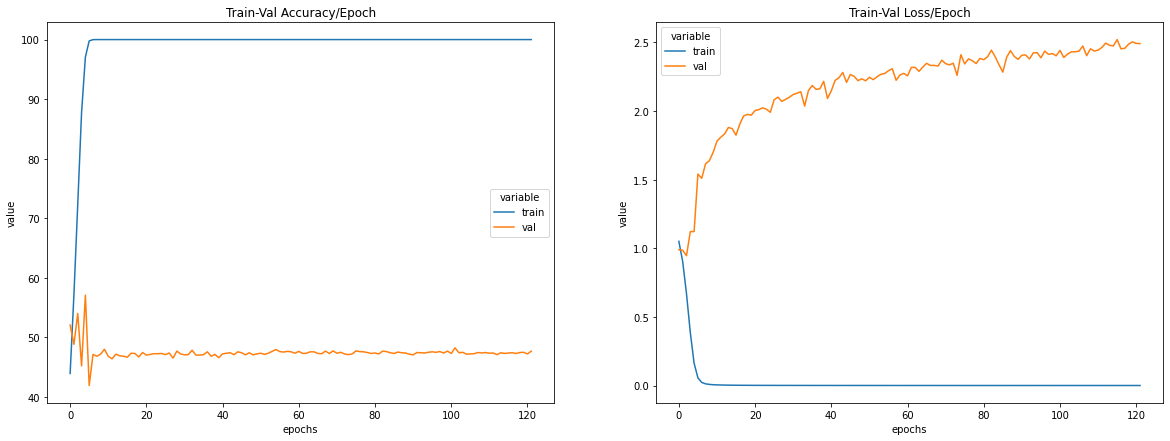

In [11]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

# Evaluate the model using Test Set

In [92]:
all_pred = []
all_preds = torch.tensor([])
y_test = torch.tensor([])
with torch.set_grad_enabled(False):
  model.eval()
  for x_test_batch, y_test_batch in test_loader:
    x_test_batch = x_test_batch.to(float).to(device)
    y_test_pred = model(x_test_batch)
    _, y_pred_probs = torch.max(y_test_pred, dim = 1)
    all_pred.append(y_pred_probs.cpu().numpy())
    all_preds = torch.cat((all_preds.cpu(), y_pred_probs.cpu()),dim = 0)
    y_test = torch.cat((y_test, y_test_batch), dim = 0) 

#all_preds = [a.squeeze().tolist() for a in all_preds]

## Create Confusion Matrix

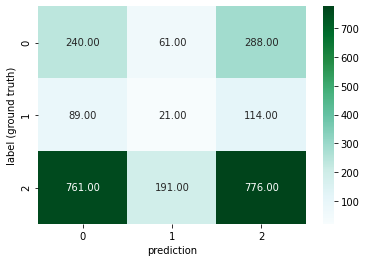

In [95]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, all_pred))#.rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [93]:

y_test

tensor([2., 2., 2.,  ..., 2., 0., 2.])

In [96]:
"""def conf_matrix(model, loader):
  model.eval()
  all_preds = torch.tensor([])
  with torch.set_grad_enabled(False):
    for batch in loader:
      x_test, y_test = batch
      x_test = x_test.to(float).to(device)
      y_test = y_test.to(float).to(device)
      preds = model(x_test)
      # concatenates all predictions per batch into one list
      all_preds = torch.cat((all_preds.cpu(), preds.cpu()),dim = 0) 
  
  print(all_preds.size())
  print(y_test_tensor.size())
  print(y_test.size())
  print(y_train_tensor.size())
  return all_preds"""






def plot_conf_matrix(matrix, class_names, session):
  df_cm = pd.DataFrame(matrix, class_names, class_names) #matrix.numpy()
  df_cm.to_csv("/content/gdrive/MyDrive/Colab Notebooks/model_charts/conf_matrix_{}".format(session))
  plt.figure(figsize = (9,6))
  sns.heatmap(df_cm, annot=True, fmt=".2f", cmap='BuGn')
  plt.xlabel("prediction")
  plt.ylabel("label (ground truth)")
  plt.show()






from sklearn.metrics import classification_report, confusion_matrix
#all_pred = conf_matrix(model, train_loader)
confmat = ConfusionMatrix(num_classes = 3)
#cmtx = confmat(y_train_tensor.cpu().numpy(), all_preds)
#cmtx = confmat(y_test, all_pred)
class_names = ["Possible Dementia", "Likely Dementia", "No Dementia"]
class_vals = [0,1,2]
#plot_conf_matrix(cmtx, class_names, 2)
print(classification_report(y_test, all_pred, class_vals))
#print(classification_report(y_train_tensor.numpy(), all_preds, class_vals))
#print(classification_report(y_train_tensor, all_pred.argmax(axis=1), class_vals))

              precision    recall  f1-score   support

           0       0.22      0.41      0.29       589
           1       0.08      0.09      0.08       224
           2       0.66      0.45      0.53      1728

    accuracy                           0.41      2541
   macro avg       0.32      0.32      0.30      2541
weighted avg       0.51      0.41      0.44      2541



# Plot ROC curve

ROC AUC score: 0.48526954484535806


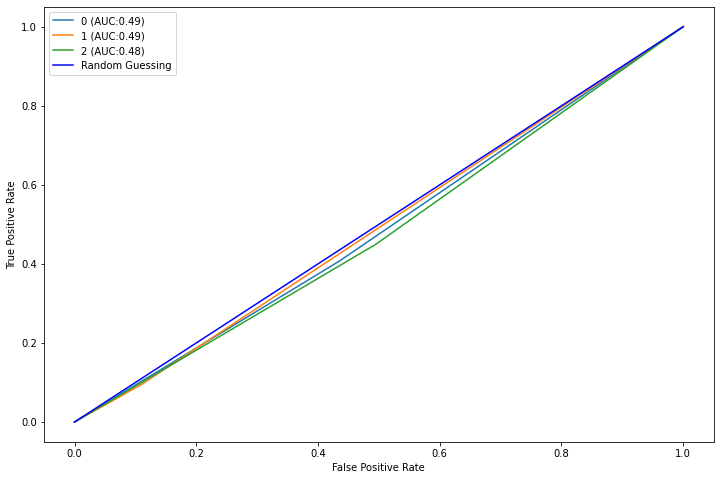

In [107]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [0, 1, 2]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test1, all_pred1, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test1)
    y_test1 = lb.transform(y_test1)
    all_pred1 = lb.transform(all_pred1)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test1[:,idx].astype(int), all_pred1[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test1, all_pred1, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, all_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## Save the GPU CNN Model
Also includes loading on GPU

In [11]:
# Save GPU model
model_name = 'model_cnn.checkpoint2'
PATH = "/content/gdrive/MyDrive/Colab Notebooks/Models/{}".format(model_name)
torch.save(model.state_dict(), PATH)

In [ ]:
# Load GPU model
device = torch.device("cuda")
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)

In [ ]:
# Calculate a Confusion Matrix of all the data
train_preds = get_all_preds(model, train_loader)
preds_correct = get_num_correct(train_preds, y_train_tensor)
print("total correct: ", preds_correct)
print("Accuracy_p: ", (preds_correct/len(training_data))*100)

total correct:  27692
Accuracy_p:  67.39516658959819
